In [7]:
import yaml
import os
import pyterrier as pt
import pandas as pd

In [8]:
BASE_PATH = "datasets/LongEval-Web"

with open(BASE_PATH + "/metadata.yml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [9]:
dataset = "longeval-web"
language = "fr"
sub_collection = "2022-07"

In [10]:
qrels = pt.io.read_qrels(BASE_PATH + f"/release_2025_p1/French/LongEval Train Collection/qrels/{sub_collection}_{language}/qrels_processed.txt")

In [15]:
index_path = os.path.join(".", BASE_PATH, f"index/{dataset}-{language}-{sub_collection}-pyterrier")
#topics_path = os.path.join(BASE_PATH, "release_2025_p1/French/queries.txt")
topics_path = os.path.join(BASE_PATH, "release_2025_p1/French/LongEval Train Collection/queries/2022-07_queries.txt")

In [16]:
#Preprocessing
topics = pd.read_csv(topics_path, sep="\t", names=["qid", "query"])
topics["qid"] = topics["qid"].astype(str)

topics["query"] = topics["query"].str.replace("'", "")
topics["query"] = topics["query"].str.replace("*", "")
topics["query"] = topics["query"].str.replace("/", "")
topics["query"] = topics["query"].str.replace(":", "")
topics["query"] = topics["query"].str.replace("?", "")
topics["query"] = topics["query"].str.replace(")", "")
topics["query"] = topics["query"].str.replace("(", "")
topics["query"] = topics["query"].str.replace("+", "")
spam = ["59769", "6060", "75200", "74351", "67599", "74238", "74207", "75100", "58130", "62893", "75177"]
topics = topics[~topics["qid"].isin(spam)]

In [18]:
topics

,qid,query
0,3,1ere guerre mondiale
1,7,3949 pole emploi
2,8,4 mariages 1 enterrement
3,11,abdl videos
4,12,abri voiture
...,...,...
4698,75323,pommes de terre au micro-ondes
4699,75329,ouest-france emploi
4700,75333,geant beaux-arts
4701,75334,megarama beaux-arts


In [371]:
#Getting csv from topics dataframe
output_path = "queries_2022-07.csv"
topics[["qid", "query"]].to_csv(output_path, index=False, header=["qid", "query"])

In [305]:
sampled_queries = topics.sample(n=100, random_state=42)  # random_state ensures reproducibility

In [309]:
# Ensure qid is of integer type
sampled_queries["qid"] = sampled_queries["qid"].astype(int)

# Sort by qid as integers
sampled_queries_sorted = sampled_queries.sort_values(by="qid")

# Save to csv
sampled_queries_sorted.to_csv("sampled_queries_2022-07.csv", index=False, encoding="utf-8")

In [306]:
sampled_queries

,qid,query
4155,29118,impots airbnb
2468,5029,mediatheque de bordeaux
2269,4572,lart de la guerre livre
497,1037,espace client boursorama
3313,27477,plombier bordeaux
...,...,...
2876,5794,test debit reseau
4499,74499,emploi-store.fr
3341,27512,prix raccordement eau
4314,29446,restaurant entre terre et mer


In [133]:
#Random annotation without LLM
import random

categories = ["time-independent", "timeliness", "event", "explicit-time"]

topics["Answer"] = topics["query"].apply(lambda x: random.choice(categories))

output_path = "queries_2022-07.csv"
topics[["qid" ,"query", "Answer"]].to_csv(output_path, index=False, header=["qid", "Prompt", "Answer"])

In [432]:
index = pt.IndexFactory.of(index_path)

20:03:38.923 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 4.3 GiB of memory would be required.


In [ ]:
# --- QUERY UNIQUE DATES FOR DOCUMENTS ---
#query = """
#SELECT d.docid, COUNT(DISTINCT j.date) AS unique_dates_count
#FROM "Document" d,
#LATERAL jsonb_array_elements_text(d.date::jsonb) AS j(date)
#WHERE d.sub_collection = '2022-07'
#GROUP BY d.docid;
#"""

#Database connection
DATABASE = "longeval-web"
USER = "dis18"
HOST = "db"
PORT = "5432"
PASSWORD = "dis182425"

#Build dynamic WHERE clause to include sub_collections <= current
sub_year, sub_month = map(int, sub_collection.split("-"))

where_clause = f"""
WHERE (substring(d.sub_collection from 1 for 4)::int < {sub_year}
       OR (substring(d.sub_collection from 1 for 4)::int = {sub_year}
           AND substring(d.sub_collection from 6 for 2)::int <= {sub_month}))
"""

# --- QUERY UNIQUE DATES FOR DOCUMENTS ---
query = f"""
SELECT d.docid, COUNT(DISTINCT j.date) AS unique_dates_count
FROM "Document" d,
LATERAL jsonb_array_elements_text(d.date::jsonb) AS j(date)
{where_clause}
GROUP BY d.docid;
"""

# Create the engine for PostgreSQL
engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

# Fetch the result as dataframe
df_dates = pd.read_sql(query, engine)
df_dates["docid"] = df_dates["docid"].astype(str)  # Ensure docid is string

#Boost documents with unique dates <= 3
boosted_docs = set(df_dates[df_dates["unique_dates_count"] <= 3]["docid"])

In [275]:
boosted_docs

{'doc1188991',
 'doc1503724',
 'doc1542175',
 'doc1568040',
 'doc1025334',
 'doc158073',
 'doc200771',
 'doc603306',
 'doc357318',
 'doc956056',
 'doc112166',
 'doc368247',
 'doc954044',
 'doc414892',
 'doc686441',
 'doc276923',
 'doc310250',
 'doc1400448',
 'doc984857',
 'doc1215214',
 'doc303100',
 'doc163715',
 'doc183335',
 'doc981425',
 'doc1460331',
 'doc1082312',
 'doc682054',
 'doc630868',
 'doc998253',
 'doc900650',
 'doc490248',
 'doc437639',
 'doc392620',
 'doc382346',
 'doc1148656',
 'doc1118258',
 'doc41986',
 'doc686550',
 'doc169636',
 'doc884406',
 'doc963524',
 'doc211645',
 'doc1470988',
 'doc697332',
 'doc482792',
 'doc954548',
 'doc1186710',
 'doc102171',
 'doc1278688',
 'doc260704',
 'doc687606',
 'doc626726',
 'doc1361725',
 'doc1540204',
 'doc664775',
 'doc466267',
 'doc808691',
 'doc1306928',
 'doc700095',
 'doc581018',
 'doc504304',
 'doc836181',
 'doc730566',
 'doc1225743',
 'doc288118',
 'doc375905',
 'doc1114284',
 'doc1168893',
 'doc360798',
 'doc1444858',


In [ ]:
import pandas as pd
import os
import pyterrier as pt
from sqlalchemy import create_engine

#Initialize pyterrier
if not pt.started():
    pt.init()

#Database connection
DATABASE = "longeval-web"
USER = "dis18"
HOST = "db"
PORT = "5432"
PASSWORD = "dis182425"

#Create engine for PostgreSQL
engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

#Build dynamic WHERE clause to include sub_collections <= current
sub_year, sub_month = map(int, sub_collection.split("-"))

where_clause = f"""
WHERE (substring(d.sub_collection from 1 for 4)::int < {sub_year}
       OR (substring(d.sub_collection from 1 for 4)::int = {sub_year}
           AND substring(d.sub_collection from 6 for 2)::int <= {sub_month}))
"""

# --- QUERY UNIQUE DATES FOR DOCUMENTS ---
query = f"""
SELECT d.docid, COUNT(DISTINCT j.date) AS unique_dates_count
FROM "Document" d,
LATERAL jsonb_array_elements_text(d.date::jsonb) AS j(date)
{where_clause}
GROUP BY d.docid;
"""

#Fetch result as dataframe
df_dates = pd.read_sql(query, engine)
df_dates["docid"] = df_dates["docid"].astype(str)  # Ensure docid is string

#Load queries from processed_queries.csv 
queries_path = "2022-07_categorized_queries.csv"

queries = pd.read_csv(queries_path, sep=",")  # Ensure proper separator

#Rename columns for compatibility
queries.rename(columns={"Prompt": "query", "Answer": "category"}, inplace=True)
queries["qid"] = queries["qid"].astype(str)  # Use existing qid values

#Setup Index and BM25
index_path = os.path.join(".", BASE_PATH, f"index/{dataset}-{language}-{sub_collection}-pyterrier")
index = pt.IndexFactory.of(index_path)
BM25 = pt.BatchRetrieve(index, wmodel="BM25", verbose=True)

#BM25 run
#run = BM25.transform(queries.head(100))
run = BM25.transform(queries)

#Boost documents with unique dates <= 3
boosted_docs = set(df_dates[df_dates["unique_dates_count"] <= 3]["docid"])

#Merge query categories into run results
run = run.merge(queries[["qid", "category"]], on="qid", how="left")

#Rename and drop unnecessary columns
run = run.drop(columns=["category_x"]).rename(columns={"category_y": "category"})

In [381]:
#Remove the 'doc' prefix from boosted_docs docids
boosted_docs = {docid[3:] for docid in boosted_docs}  # Remove the first 3 characters ('doc')

In [382]:
run["docno"] = run["docno"].str.strip("doc")  # the indexed documents prefix the docid with `doc`, this needs to be removed

In [383]:
def apply_boost_and_rerank(run_df, boosted_docs_set, boost_value):
    run = run_df.copy()
    run['docid'] = run['docid'].astype(str)
    
    #Apply boost logic
    mask = run['docid'].isin(boosted_docs_set) & (run['category'] != 'not-temporal')
    run['boost'] = np.where(mask, boost_value, 1.0)

    run['score'] = run['score'] * run['boost']

    #Rerank and assign new rank
    run = run.sort_values(by=["qid", "score"], ascending=[True, False])
    run["rank"] = run.groupby("qid").cumcount()

    return run

In [384]:
class BoostReranker(pt.Transformer):
    def __init__(self, run_df, boosted_docs_set, boost_value):
        self.run_df = run_df
        self.boosted_docs = boosted_docs_set
        self.boost_value = boost_value

    def transform(self, topics):
        return apply_boost_and_rerank(self.run_df, self.boosted_docs, self.boost_value)

In [385]:
import numpy as np

boost_values = np.arange(1.0, 2.1, 0.01)
pipelines = [BoostReranker(run, boosted_docs, b) for b in boost_values]

results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    names=[f"boost={b:.3f}" for b in boost_values],
    verbose=True
)

pt.Experiment: 100%|██████████| 110/110 [23:12<00:00, 12.66s/system]


In [386]:
best_boost = results.sort_values("ndcg", ascending=False).iloc[0]
print("Best boost value based on ndcg:", best_boost["name"])

Best boost value based on ndcg: boost=1.020


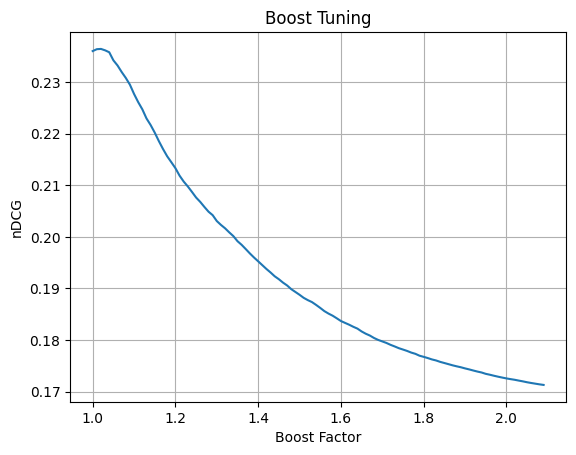

In [387]:
import matplotlib.pyplot as plt

plt.plot(boost_values, results["ndcg"])
plt.xlabel("Boost Factor")
plt.ylabel("nDCG")
plt.title("Boost Tuning")
plt.grid(True)
plt.show()

In [409]:
import itertools
import numpy as np
import pandas as pd
import pyterrier as pt

#Define boost ranges for each category
category_boost_ranges = {
    "time-independent": np.arange(1.0, 1.21, 0.05),
    "explicit-time": np.arange(1.0, 1.21, 0.05),
    "event": np.arange(1.0, 1.21, 0.05),
    "timeliness": np.arange(1.0, 1.21, 0.05)
}

#All combinations of the boost values
boost_combinations = list(itertools.product(
    category_boost_ranges["time-independent"],
    category_boost_ranges["explicit-time"],
    category_boost_ranges["event"],
    category_boost_ranges["timeliness"]
))

#Create a mapping from docid to its category
doc_category_map = dict(zip(run["docid"].astype(str), run["category"]))

#Boost logic that applies per document based on its category
def apply_category_boost(run_df, category_boosts):
    run = run_df.copy()
    run['docid'] = run['docid'].astype(str)

    def get_boost(docid):
        category = doc_category_map.get(docid, "time-independent")
        return category_boosts.get(category, 1.0)

    run['boost'] = run['docid'].apply(get_boost)
    run['score'] = run['score'] * run['boost']

    run = run.sort_values(by=["qid", "score"], ascending=[True, False])
    run["rank"] = run.groupby("qid").cumcount()
    return run

#BoostReranker that takes category_boosts
class CategoryBoostReranker(pt.Transformer):
    def __init__(self, run_df, category_boosts):
        self.run_df = run_df
        self.category_boosts = category_boosts

    def transform(self, topics):
        return apply_category_boost(self.run_df, self.category_boosts)

#Create reranking pipelines for each combination
pipelines = []
names = []

for combo in boost_combinations:
    category_boosts = {
        "time-independent": combo[0],
        "explicit-time": combo[1],
        "event": combo[2],
        "timeliness": combo[3]
    }
    pipelines.append(CategoryBoostReranker(run, category_boosts))
    names.append(
        f"TI={combo[0]:.2f},ET={combo[1]:.2f},EV={combo[2]:.2f},TL={combo[3]:.2f}"
    )

#Run PyTerrier experiment
results = pt.Experiment(
    pipelines,
    queries,
    qrels,
    eval_metrics=["ndcg", "map", "bpref", "P.10", "ndcg_cut_10"],
    names=names,
    verbose=True
)

#Print best boost config
best_result = results.sort_values("ndcg", ascending=False).iloc[0]
print("Best boost configuration:")
print(best_result)


pt.Experiment: 100%|██████████| 625/625 [2:14:16<00:00, 12.89s/system]  

Best boost configuration:
name           TI=1.20,ET=1.15,EV=1.15,TL=1.20
ndcg                                    0.2174
map                                    0.12785
bpref                                 0.412449
P.10                                  0.048362
ndcg_cut_10                           0.154545
Name: 594, dtype: object


In [60]:
#Remove the 'doc' prefix from boosted_docs docids
test_boosted_docs = {docid[3:] for docid in boosted_docs}  # Remove the first 3 characters ('doc')

#Run['docid'] is a number, should also ensure it's a string
run['docid'] = run['docid'].astype(str)

#Convert run['docid'] to a set to get all unique docids
run_docids = set(run['docid'])

#Find the intersection of docids in run and boosted_docs
overlap = run_docids.intersection(test_boosted_docs)

#Print the overlapping docids
print("Overlapping docids:", overlap)

#Print how many overlapping docids there are
print(f"Number of overlapping docids: {len(overlap)}")

Overlapping docids: {'443755', '1204112', '326931', '1365997', '252074', '163850', '733784', '427398', '1178689', '925941', '1372960', '404569', '1147236', '1009790', '1246536', '324832', '33620', '839461', '626583', '733104', '1047109', '1182680', '747655', '75758', '749903', '312758', '1529369', '1111425', '1030108', '1319478', '647915', '986930', '684668', '1281584', '1334575', '758366', '1083384', '1545126', '560752', '479245', '1057794', '676917', '1087747', '72452', '963595', '740415', '88001', '182844', '564455', '881710', '747566', '1387766', '566857', '1055255', '435995', '886255', '1071529', '82301', '955978', '1038726', '1001309', '866298', '961733', '443343', '1440490', '6542', '322698', '1245196', '1203843', '1585904', '1270387', '1260949', '1525835', '512252', '1234607', '58953', '1514', '171730', '1223065', '997217', '113846', '1044146', '1051839', '1430830', '726308', '897383', '917128', '1196222', '313028', '950065', '752686', '963843', '1562556', '1431528', '1539336',

In [358]:
#Remove the 'doc' prefix from boosted_docs docids
boosted_docs = {docid[3:] for docid in boosted_docs}  # Remove the first 3 characters ('doc')

#Ensure the 'docid' in run is a string (match with boosted_docs)
run['docid'] = run['docid'].astype(str)

#Create the 'boost' column, initialize with 1 (default boost)
run['boost'] = 1

#Apply boost for documents that are in boosted_docs and category is not 'time-independent'
for idx, row in run.iterrows():
    if row['docid'] in boosted_docs and row['category'] != 'not-temporal':
        run.at[idx, 'boost'] = 1.03  # Apply 1.3 boost for matching docid and category condition

#Apply boost to the score
run['score'] = run['score'] * run['boost']

/tmp/ipykernel_141/2638686409.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.03' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  run.at[idx, 'boost'] = 1.03  # Apply 1.3 boost for matching docid and category condition


In [212]:
run

,qid,docid,docno,rank,score,query,category,boost
0,157,311960,389492,0,40.335696,avast antivirus,not-temporal,1.0
1,157,737532,7045,1,52.052762,avast antivirus,not-temporal,1.3
2,157,872881,360940,2,39.869887,avast antivirus,not-temporal,1.0
3,157,734259,3785,3,39.829858,avast antivirus,not-temporal,1.0
4,157,1174439,380428,4,39.687561,avast antivirus,not-temporal,1.0
...,...,...,...,...,...,...,...,...
93597,349,496530,1416601,995,13.606549,cadeau fete des meres,implicit-temporal,1.0
93598,349,496323,1416410,996,13.598510,cadeau fete des meres,implicit-temporal,1.0
93599,349,173468,1414408,997,13.586851,cadeau fete des meres,implicit-temporal,1.0
93600,349,1398588,344271,998,13.578586,cadeau fete des meres,implicit-temporal,1.0


In [359]:
#Rerank based on boosted score
run = run.sort_values(by=["qid", "score"], ascending=[True, False])

#Assign new rank per qid group
run["rank"] = run.groupby("qid").cumcount()

In [ ]:
#Filter rows where the boost is 1.03
boosted_rows = run[run['boost'] == 1.03]

#Show the boosted rows
print(boosted_rows)

In [96]:
print(run.dtypes)
print( )
print(qrels.dtypes)

qid          object
docid        object
docno        object
rank          int64
score       float64
query        object
category     object
boost       float64
dtype: object

qid      object
docno    object
label     int64
dtype: object


In [230]:
run["docno"] = run["docno"].str.strip("doc")  #the indexed documents prefix the docid with `doc`, this needs to be removed

In [357]:
#no boost
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  6.47system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank scor...,0.39251,0.154989,0.240067,0.18488,0.046


In [360]:
#boost 1.03
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  3.54system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score...,0.39251,0.154958,0.240009,0.18488,0.046


## Old Experiments

Old experiments where the pipeline either wasn't working properly or when everything was still experimental

In [224]:
#boost 1.3
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  5.47system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score ...,0.460568,0.136389,0.228582,0.163755,0.048


In [149]:
#boost 1.3
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:07<00:00,  7.10s/system]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score...,0.434687,0.12031,0.212069,0.141183,0.042107


In [152]:
#no boost
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:06<00:00,  6.22s/system]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank sc...,0.441952,0.145868,0.236045,0.172419,0.051764


In [43]:
#no boost
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:07<00:00,  7.88s/system]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score...,0.002822,0.000016,0.000392,0.0,0.0


In [130]:
#boost 1.05
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  5.63system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score ...,0.086136,0.007301,0.035876,0.012159,0.007317


In [125]:
#boost 1.1
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  5.78system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score ...,0.086136,0.007413,0.03605,0.012422,0.007317


In [120]:
#boost 1.2
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  5.71system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score ...,0.086136,0.007443,0.036092,0.012539,0.007317


In [106]:
#boost 1.3
pt.Experiment(
    [run],
    queries,
    qrels,
    eval_metrics=["bpref", "map", "ndcg", "ndcg_cut_10", "P.10"],
    verbose=True
)

pt.Experiment: 100%|██████████| 1/1 [00:00<00:00,  5.46system/s]


,name,bpref,map,ndcg,ndcg_cut_10,P.10
0,qid docid docno rank score ...,0.086136,0.00743,0.03607,0.012539,0.007317
